In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import seaborn as sn
import os
import matplotlib.pyplot as plt
import random
import shutil
import pandas as pd
import numpy as np
from ModelEval import *

##### Input size = [3, 271, 781]

In [6]:
def swish(x):
    return x/(1+torch.exp(-x))

# Custom 2d average pooling. Used directly prior to the fully connected layer(s)
#
# dims: Tuple representing the two dimensions to pool.
# keep_dims: Boolean determining if output should preserve number of input dimensions.
def avg_pool(x, dims, keep_dims=False):
    summed_tensor = torch.sum(x, dim=dims)
    if keep_dims:
        reshaped_tensor = summed_tensor.unsqueeze(dim=dims[0]).unsqueeze(dim=dims[1])
        return reshaped_tensor
    return summed_tensor

In [7]:
# MobileNET arch
class SingNET(nn.Module):
    def __init__(self):
        super(SingNET, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer7_12 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.layer14 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.fc = nn.Linear(512, 209)
        
        
        
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.relu(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7_12(out)
        out = self.layer7_12(out)
        out = self.layer7_12(out)
        out = self.layer7_12(out)
        out = self.layer7_12(out)
        out = self.layer7_12(out)
        out = self.layer13(out)
        out = self.layer14(out)
        
        out = avg_pool(out, (2,3))
        out = self.fc(out)
        return out
        
        

In [8]:
# img = Image.open("data/costa_rica/train_dn/Yellow-throated_Toucan/Yellow-throated_Toucan_146_0dn.jpg")
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# img_tensor = transform(img).unsqueeze(0)
# print(img_tensor.size())

In [9]:
# data_transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])])
# train_set = ImageFolder("data/train_refined", transform=data_transform)
# train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=1)

# class_stats = compute_class_stats(train_loader)

In [10]:
class_stats = (209, 37937, [269, 63, 500, 290, 111, 238, 500, 4, 111, 324, 27, 8, 111, 46, 500, 38, 
                            83, 46, 396, 246, 500, 167, 4, 23, 51, 15, 8, 29, 92, 54, 180, 97, 195, 
                            60, 222, 81, 27, 12, 41, 277, 315, 348, 86, 18, 219, 67, 45, 209, 5, 61, 
                            24, 135, 195, 44, 500, 351, 500, 453, 500, 500, 332, 332, 68, 189, 83, 77, 
                            396, 242, 255, 50, 326, 12, 500, 116, 1, 500, 500, 234, 34, 38, 28, 114, 278, 
                            90, 17, 500, 187, 47, 208, 58, 26, 29, 500, 279, 500, 172, 207, 500, 99, 207, 
                            63, 4, 500, 14, 6, 5, 55, 113, 432, 339, 34, 168, 20, 36, 86, 50, 257, 500, 179, 
                            209, 98, 42, 87, 3, 65, 41, 83, 112, 261, 500, 394, 142, 147, 14, 156, 84, 500, 
                            256, 2, 71, 59, 270, 264, 5, 15, 467, 73, 153, 58, 132, 201, 131, 69, 74, 43, 230, 
                            108, 500, 75, 218, 15, 343, 58, 20, 167, 239, 216, 29, 99, 500, 202, 141, 72, 87, 500, 
                            140, 70, 72, 463, 91, 138, 213, 126, 80, 1, 97, 500, 280, 24, 27, 42, 53, 500, 51, 500, 
                            93, 145, 9, 264, 500, 495, 281, 500, 87, 307, 201, 18, 156, 500])


In [6]:
net = SingNET()
#net.load_state_dict(torch.load("saved_models/sing_01_t5.pt"))
num_params = sum(p.numel() for p in net.parameters())
print(num_params)

1492241


In [9]:
def train(net, train_stats, epochs=100, batch_size=8, lr=0.005, L2_reg=0.01, saved_filepath="saved_models/test_model.pt"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device in use: {device}")
    if device == "cuda":
        torch.cuda.empty_cache()
        #torch.cuda.max_memory_allocated(max_split_size_mb=1024)
    net.to(device)
    print("==> Starting Data Preparation...")
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])
    train_set = ImageFolder("data/train_refined", transform=data_transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
    val_set = ImageFolder("data/validation_refined", transform=data_transform)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=1)
    
    num_classes, total_samples, class_samples = train_stats
    weights = torch.FloatTensor([total_samples / (num_classes * s) for s in class_samples]).to(device)
    loss_function = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2_reg)
    #scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs*0.5), int(epochs*0.75)], gamma=0.1)
    best_acc = 0
    
    print("==> Training Initiated...")
    for epoch in range(0, epochs):
        print(f"Epoch {epoch}/{epochs}")
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net.forward(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print(f"Train Loss: {round(train_loss,3)} | Train Acc: {round(correct/total,3)}")
        #scheduler.step()
        
        net.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net.forward(inputs)
                loss = loss_function(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        val_acc = correct/total
        
        print(f"Val Loss:   {round(val_loss,3)} | Val Acc:   {round(val_acc,3)}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving Model...")
            torch.save(net.state_dict(), saved_filepath)
    
    print("=========> Training Complete <=========")
    print(f"Best Validation Accuracy: {best_acc}")
            
            
    

In [7]:
net = SingNET()
train(net, class_stats, epochs=50, batch_size=8, lr=0.001, L2_reg=0.04, saved_filepath="saved_models/sing_02.pt")

1000/8579
2000/8579
3000/8579
4000/8579
5000/8579
6000/8579
7000/8579
8000/8579


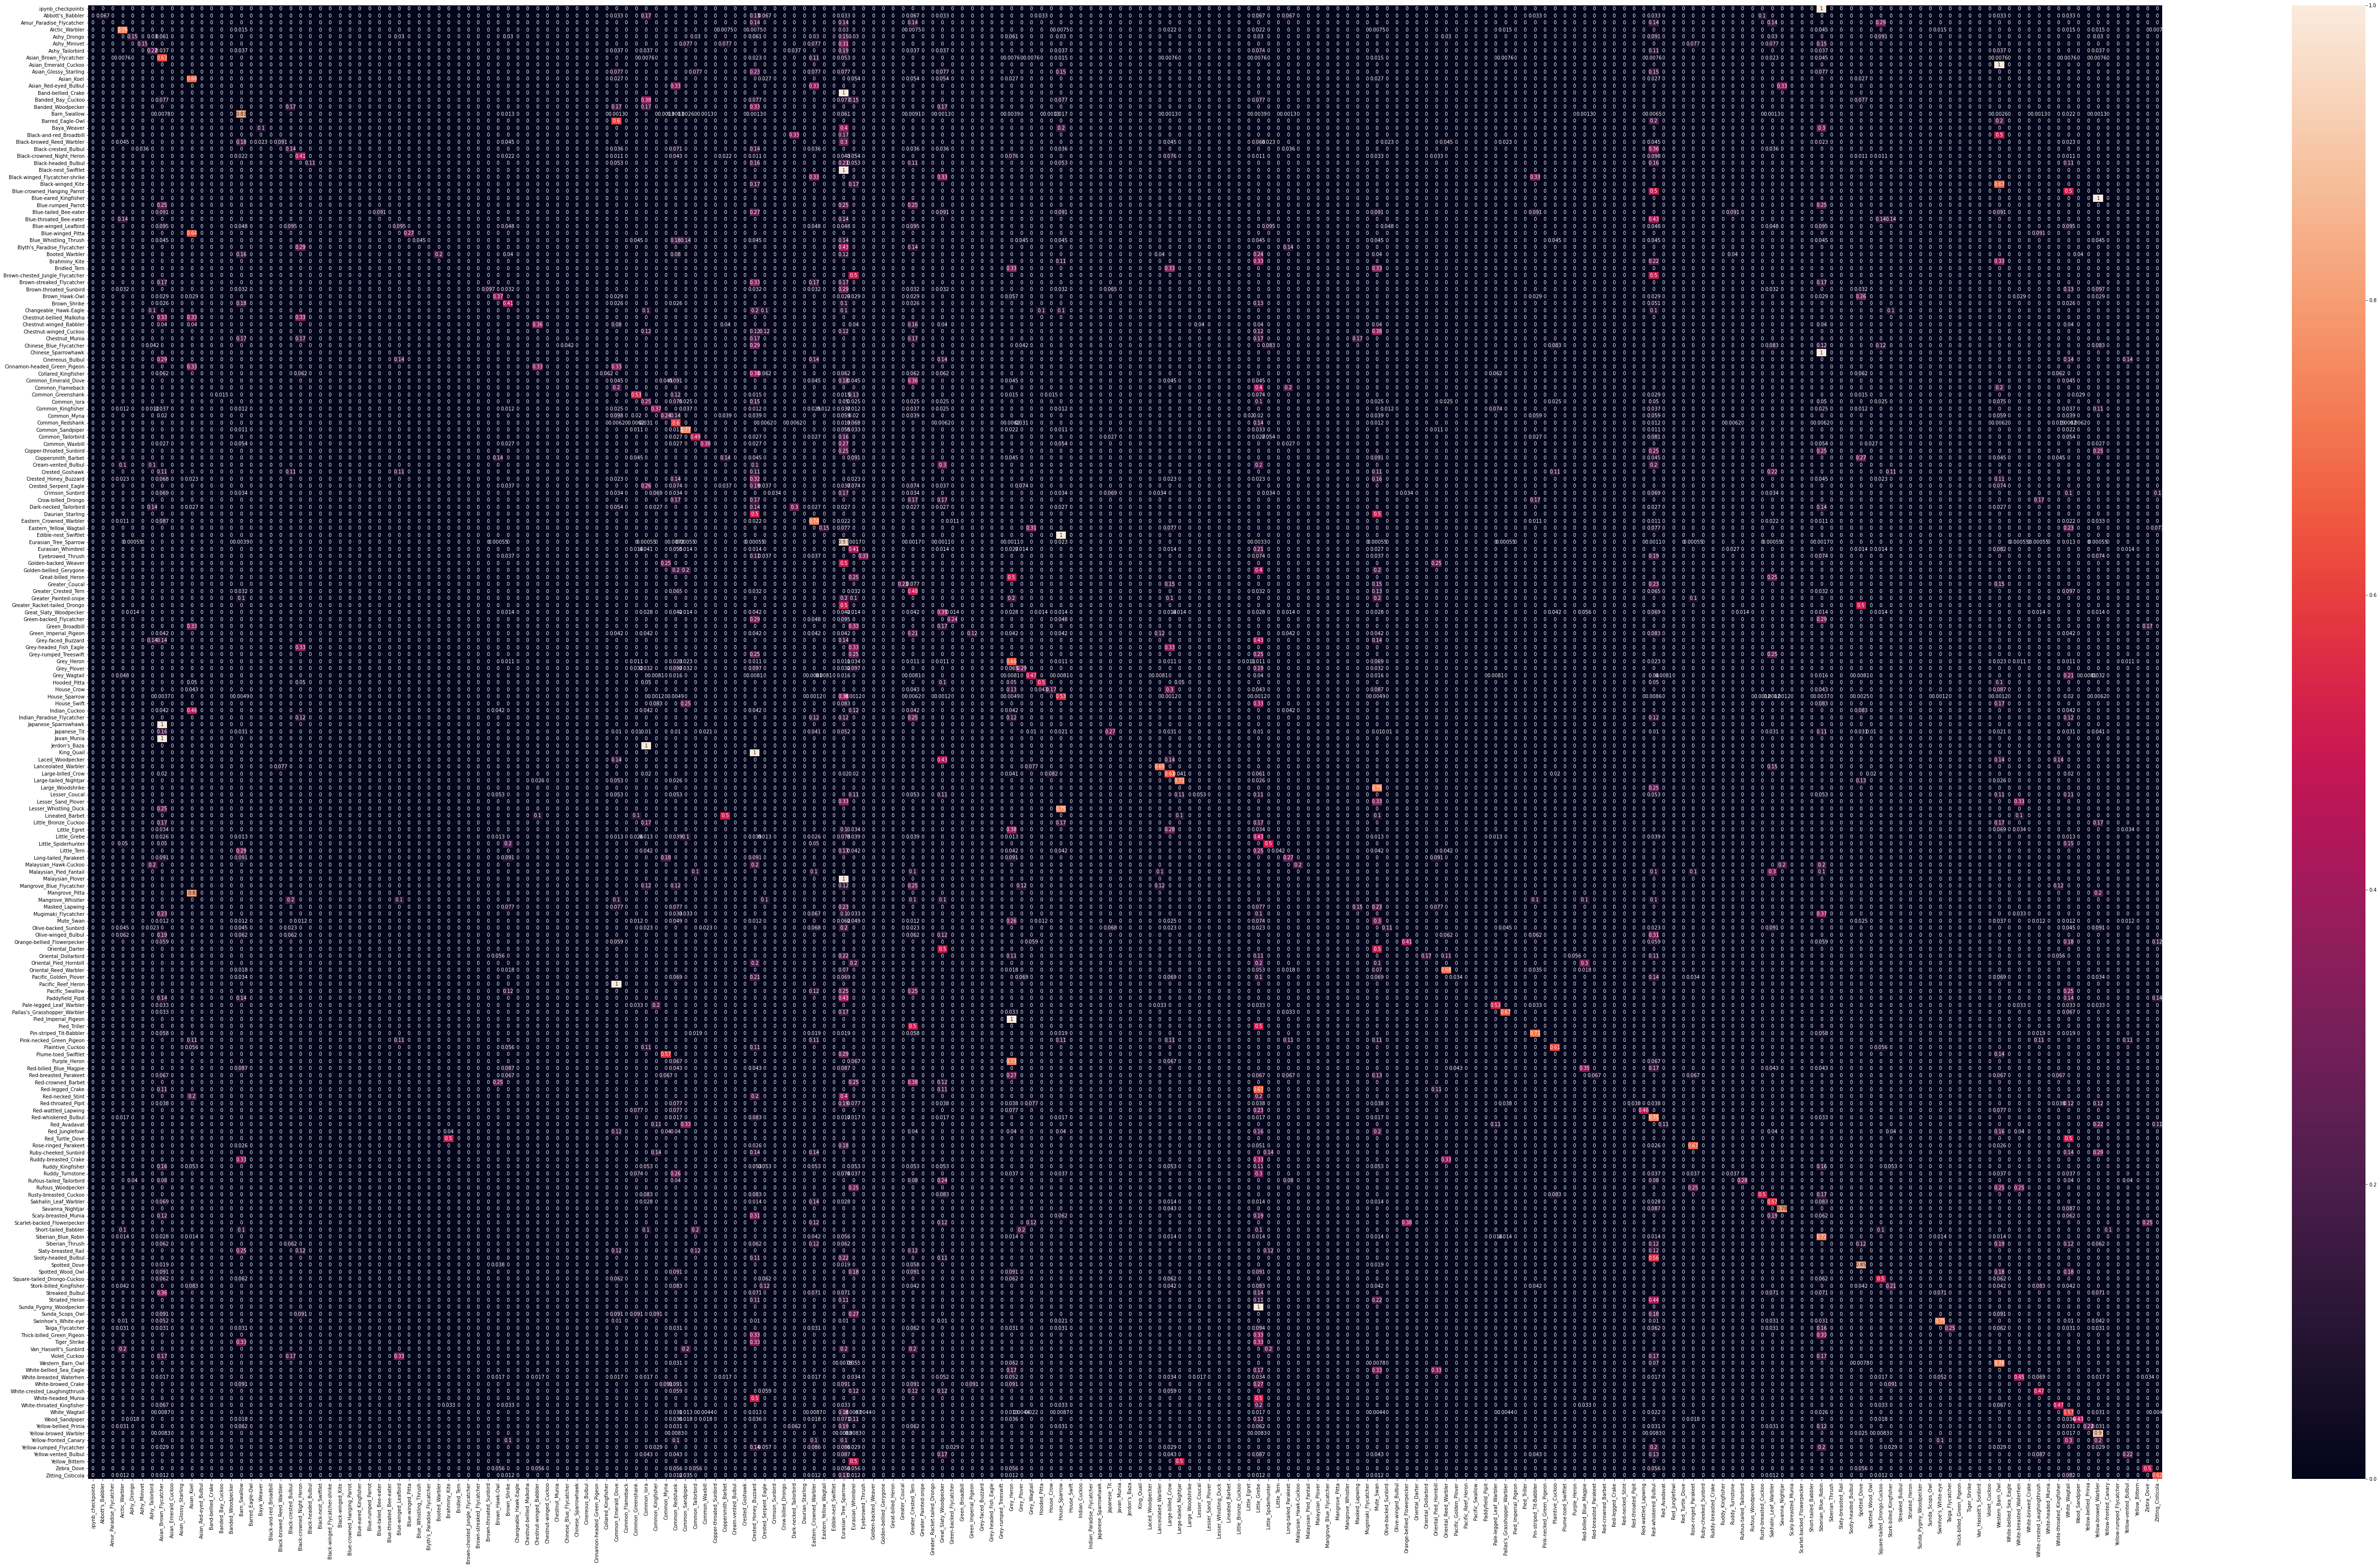

AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'

In [12]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])
val_set = ImageFolder("data/validation", transform=data_transform)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=1)

model = SingNET()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.load_state_dict(torch.load("saved_models/sing_01_t6.pt"))

generate_confusion_matrix(model, val_loader, "data/train")
#test_model(model, val_loader)